In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split, KFold

In [3]:
#pd.set_option('display.max_rows', None)
def show_all(df, nrow, ncol):
    with pd.option_context('display.max_rows', nrow, 'display.max_columns', ncol):
        display(df)

In [4]:
fci_df = pd.read_csv("fulfilment_center_info.csv")
mi_df = pd.read_csv("meal_info.csv")
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sub_df = pd.read_csv("sample_submission.csv")

In [5]:
fci_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [6]:
print("Shape of fulfilment_center_info :", fci_df.shape)

('Shape of fulfilment_center_info :', (77, 5))


In [7]:
# NaN values in fulfilment_center_info
fci_df.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [8]:
# head of meal_info file
mi_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [9]:
print("Shape of meal_info: ", mi_df.shape)

('Shape of meal_info: ', (51, 3))


In [10]:
# NaN values in meal_info
mi_df.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

In [11]:
# Head of Train file (historical demand data)
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [12]:
print("Shape of train: ", train_df.shape)

('Shape of train: ', (456548, 9))


In [13]:
# NaN values in train data
train_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [14]:
# Head of Test data
test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [15]:
print("Shape of Test: ", test_df.shape)

('Shape of Test: ', (32573, 8))


In [16]:
# NaN values in test data
test_df.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

In [17]:
train_df = pd.merge(train_df, fci_df, on='center_id')
test_df = pd.merge(test_df, fci_df, on='center_id')

train_df = pd.merge(train_df, mi_df, on='meal_id')
test_df = pd.merge(test_df, mi_df, on='meal_id')

In [18]:
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [19]:
train_df['train_or_test'] = 'train'
test_df['train_or_test'] = 'test'

In [21]:
train_df['num_orders'] = np.log1p(train_df['num_orders'])

In [23]:
all_df = train_df.append(test_df).reset_index(drop=True)[train_df.columns]

In [26]:
all_df = all_df.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [27]:
all_df['checkout_price'] = np.log1p(all_df['checkout_price'])
all_df['base_price'] = np.log1p(all_df['base_price'])

In [28]:
all_df['discount_on_base'] = (all_df['base_price'] - all_df['checkout_price']) / all_df['base_price']

In [29]:
all_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test,discount_on_base
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,56,TYPE_B,6.3,Beverages,Italian,train,0.000000
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.001044
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002082
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,56,TYPE_B,6.3,Beverages,Italian,train,0.001043
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,56,TYPE_B,6.3,Beverages,Italian,train,-0.002095


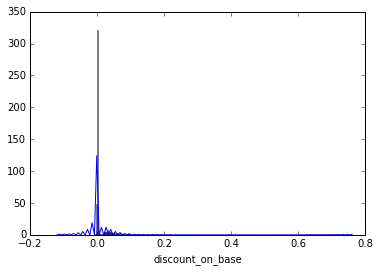

In [33]:
import seaborn as sns
sns.distplot(all_df['discount_on_base'], bins=500)
plt.show()

In [34]:
all_df['neg_discount'] = (all_df['discount_on_base'] < 0).astype(int)

In [43]:
(all_df['checkout_price'].shift(1) - all_df['checkout_price']).fillna(1)

0         1.000000
1        -0.010743
2        -0.005410
3         0.010848
4        -0.005602
5         0.122996
6         0.012156
7         0.000186
8        -0.012342
9         0.006152
10       -0.012083
11       -0.122312
12        0.016153
13        0.010694
14       -0.016161
15       -0.015904
16        0.127714
17        0.005933
18        0.018012
19        0.000187
20        0.000000
21       -0.012231
22       -0.005968
23       -0.106942
24       -0.016076
25        0.000000
26        0.005439
27        0.005140
28       -0.005140
29        0.117579
            ...   
489091    0.042397
489092    0.000000
489093    0.001717
489094   -0.003430
489095    0.000000
489096    0.000000
489097    0.003430
489098    0.000000
489099   -0.003430
489100    0.000000
489101    0.001714
489102   -0.001714
489103    0.001714
489104   -0.001714
489105    0.000000
489106    0.000000
489107    0.000000
489108    0.181627
489109    0.002055
489110   -0.181968
489111    0.000000
489112   -0.

In [35]:
all_df['price_last_curr_diff'] = (all_df['checkout_price'].shift(1) - all_df['checkout_price']).fillna(1)/ all_df['checkout_price'].shift(1).fillna(1)

In [42]:
for _, r in all_df.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    all_df.loc[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']==r['week']), 'price_last_curr_diff'] = all_df[(all_df['center_id']==r['center_id']) & (all_df['meal_id']==r['meal_id']) & (all_df['week']!=r['week'])]['price_last_curr_diff'].mean()

In [44]:
all_df['price_last_curr_diff'] = all_df['price_last_curr_diff'].fillna(0)

In [45]:
all_df['price_increase'] = (all_df['price_last_curr_diff'] < 0).astype(int)

In [46]:
# Monthwise aggregated sales values
def create_sales_agg_monthwise_features(df, gpby_cols, target_col, agg_funcs):
    '''
    Creates various sales agg features with given agg functions  
    '''
    gpby = df.groupby(gpby_cols)
    newdf = df[gpby_cols].drop_duplicates().reset_index(drop=True)
    for agg_name, agg_func in agg_funcs.items():
        aggdf = gpby[target_col].agg(agg_func).reset_index()
        aggdf.rename(columns={target_col:target_col+'_'+agg_name}, inplace=True)
        newdf = newdf.merge(aggdf, on=gpby_cols, how='left')
    return newdf